## Robuste Datengenerierung SHAP-Methode

## Ausgabe unterdrücken

In [3]:
import time
import contextlib
import io
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")



# ─── Augmentationsfunktionen ──────────────────────────────────────────────────────────
def perform_clustering(X_sub, max_clusters=4):
            cols = [col for col in X_sub.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]
            X_num = X_sub[cols]
            corr = X_num.corr().abs().fillna(0)
            corr = (corr + corr.T) / 2
            dist = np.clip(1 - corr, a_min=0, a_max=None)
            dists = squareform(dist.values)
            Z = linkage(dists, method='ward')
            cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
            clusters = {}
            for col, label in zip(cols, cluster_labels):
                clusters.setdefault(label, []).append(col)
            return clusters

def augment_subgroup(X_sub, clusters, p_augment=0.7):
    augmented_rows = []
    cluster_params = {}
    for cl_id, cols in clusters.items():
        cluster_data = X_sub[cols]
        mu = cluster_data.mean().values
        if len(cols) == 1:
            cov = np.cov(cluster_data.values.flatten(), ddof=0)
            cov = np.atleast_2d(cov)
        else:
            cov = np.cov(cluster_data.values, rowvar=False)
        cluster_params[cl_id] = (mu, cov, cols)
    for idx, row in X_sub.iterrows():
        new_row = row.copy()
        for cl_id, (mu, cov, cols) in cluster_params.items():
            if np.random.rand() < p_augment:
                new_values = np.random.multivariate_normal(mu, cov)
                for col, val in zip(cols, new_values):
                    new_row[col] = val
        augmented_rows.append(new_row)
    augmented_df = pd.DataFrame(augmented_rows)
    for col in ["Geschlecht_weiblich", "Verletzungsstatus"]:
        if col in augmented_df.columns:
            augmented_df[col] = augmented_df[col].astype(int)
    return augmented_df

def process_group_cluster(group_df, num_new_samples, max_clusters, p_augment):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    return pd.concat(aug_list, axis=0)

def augment_training_data_cluster(X_train, y_train, num_new_samples=1, max_clusters=4, p_augment=0.7, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster)(group_df, num_new_samples, max_clusters, p_augment)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def add_noise_to_data(df, noise_factor=0.1):
    df_noisy = df.copy()
    numeric_cols = [col for col in df_noisy.select_dtypes(include=['float64', 'int64']).columns 
                    if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    for col in numeric_cols:
        std = df_noisy[col].std()
        noise = np.random.normal(0, std * noise_factor, size=df_noisy.shape[0])
        df_noisy[col] += noise
    return df_noisy

def add_noise_to_group(df_group, noise_factor=0.1):
    return add_noise_to_data(df_group, noise_factor=noise_factor)

def process_group_cluster_noise(group_df, num_new_samples, max_clusters, p_augment, noise_factor):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    aug_group = pd.concat(aug_list, axis=0).reset_index(drop=True)
    n = len(aug_group)
    half = n // 2
    global_noise = add_noise_to_data(aug_group.copy(), noise_factor=noise_factor)
    group_noise = add_noise_to_group(aug_group.copy(), noise_factor=noise_factor)
    aug_noisy = pd.concat([global_noise.iloc[:half], group_noise.iloc[:half]], axis=0)
    return aug_noisy

def augment_training_data_cluster_noise(X_train, y_train, num_new_samples=1, max_clusters=4, 
                                        p_augment=0.7, noise_factor=0.1, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster_noise)(group_df, num_new_samples, max_clusters, p_augment, noise_factor)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def process_group_means(group_df, group_new_samples):
    group_df = group_df.reset_index(drop=True)
    new_group_samples = []
    if len(group_df) < 2:
        return None
    numeric_cols = [col for col in group_df.columns if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    pairs = np.random.choice(len(group_df), (group_new_samples, 2), replace=True)
    for i in range(group_new_samples):
        sample1 = group_df.iloc[pairs[i, 0]]
        sample2 = group_df.iloc[pairs[i, 1]]
        mean_sample = sample1.copy()
        for col in numeric_cols:
            mean_sample[col] = (sample1[col] + sample2[col]) / 2
        mean_sample["Verletzungsstatus"] = sample1["Verletzungsstatus"]
        mean_sample["Geschlecht_weiblich"] = sample1["Geschlecht_weiblich"]
        new_group_samples.append(mean_sample)
    if new_group_samples:
        return pd.DataFrame(new_group_samples)
    return None

def augment_data_by_group_means(X_train, y_train, augmentation_factor=2, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])
    total_original_samples = len(df_train)
    total_new_samples = int(total_original_samples * (augmentation_factor - 1))
    group_sizes = groups.size()
    group_proportions = group_sizes / total_original_samples
    tasks = []
    for (injury_status, is_female), group_df in groups:
        group_new_samples = int(total_new_samples * group_proportions[(injury_status, is_female)])
        tasks.append((group_df, group_new_samples))
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_means)(group_df, group_new_samples)
        for group_df, group_new_samples in tasks
    )
    augmented_groups = [group for group in augmented_groups if group is not None]
    augmented_df = pd.concat([df_train] + augmented_groups, ignore_index=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def augment_training_data_combined(X_train, y_train, target_size=1000, verbose=True, n_jobs=-1,
                                max_clusters=4, noise_factor=0.1):
    start_time = time.time()
    N = len(X_train)
    additional_needed = max(target_size - N, 0)
    per_method_needed = additional_needed // 3
    num_new_samples = max(per_method_needed // N, 1)
    augmentation_factor = 1 + (per_method_needed / N)
    if verbose:
        print(f"Starting combined augmentation to reach target size: {target_size}")
        print(f"Original dataset size: {N}")
        print(f"Samples needed per method: {per_method_needed}")
    funcs_and_params = [
        (augment_training_data_cluster, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_training_data_cluster_noise, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_data_by_group_means, {"augmentation_factor": augmentation_factor, "n_jobs": n_jobs})
    ]
    results = Parallel(n_jobs=min(3, n_jobs))(
        delayed(lambda f, p: f(X_train, y_train, **p))(func, params) for func, params in funcs_and_params
    )
    X_aug_cluster, y_aug_cluster = results[0]
    X_aug_cluster_noise, y_aug_cluster_noise = results[1]
    X_aug_group_means, y_aug_group_means = results[2]
    def subsample(X_aug, y_aug, required):
        if len(X_aug) > required:
            idx = np.random.choice(len(X_aug), required, replace=False)
            return X_aug.iloc[idx].reset_index(drop=True), y_aug.iloc[idx].reset_index(drop=True)
        else:
            return X_aug, y_aug
    X_aug_cluster, y_aug_cluster = subsample(X_aug_cluster, y_aug_cluster, per_method_needed)
    X_aug_cluster_noise, y_aug_cluster_noise = subsample(X_aug_cluster_noise, y_aug_cluster_noise, per_method_needed)
    X_aug_group_means, y_aug_group_means = subsample(X_aug_group_means, y_aug_group_means, per_method_needed)
    X_aug_combined = pd.concat([X_aug_cluster, X_aug_cluster_noise, X_aug_group_means], axis=0).reset_index(drop=True)
    y_aug_combined = pd.concat([y_aug_cluster, y_aug_cluster_noise, y_aug_group_means], axis=0).reset_index(drop=True)
    X_total = pd.concat([X_train.reset_index(drop=True), X_aug_combined], axis=0).reset_index(drop=True)
    y_total = pd.concat([y_train.reset_index(drop=True), y_aug_combined], axis=0).reset_index(drop=True)
    if len(X_total) > target_size:
        idx = np.random.choice(len(X_total), target_size, replace=False)
        X_total = X_total.iloc[idx].reset_index(drop=True)
        y_total = y_total.iloc[idx].reset_index(drop=True)
    elapsed_time = time.time() - start_time
    if verbose:
        print(f"Augmentation completed. Final dataset size: {len(X_total)}")
        print(f"Augmentation took {elapsed_time:.2f} seconds")
    return X_total, y_total


# ─── Modell erstellen ──────────────────────────────────────────────────────────
def create_model(input_dim):

    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# ─── ZELLE 2: DATEN FÜR PLOTS SAMMELN ────────────────────────────────────────────────

def collect_shap_data(
    data_path,
    target_column="Verletzungsstatus",
    cv_splits=5,
    cv_repeats=2,
    target_augmentation_multiplier=11,
    shap_background_size=100,
    verbose=False
):
    # 1) Daten einlesen
    df = pd.read_excel(data_path)
    y  = df[target_column]
    X  = df.drop(columns=[target_column])

    # 2) CV-Setup
    cv = RepeatedStratifiedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=42)
    metrics = []
    all_shap = []
    all_X    = []

    # 3) KernelExplainer + CV
    shap.initjs()
    print("→ Starte SHAP-Berechnungen über alle CV-Folds...")
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), start=1):
        if verbose: print(f"Fold {fold}")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Augmentation & Skalierung
        target_size = int(len(X_train) * target_augmentation_multiplier)
        X_train, y_train = augment_training_data_combined(
            X_train, y_train,
            target_size=target_size,
            verbose=verbose,
            n_jobs=-1,
            max_clusters=4,
            noise_factor=0.1
        )

        # Skalierung & Cleaning
        scaler = MinMaxScaler()
        X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test_s  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

        # SHAP-safe Vorbereitung
        X_train_s = X_train_s.astype(np.float32).replace([np.inf, -np.inf], np.nan).fillna(0)
        X_test_s  = X_test_s.astype(np.float32).replace([np.inf, -np.inf], np.nan).fillna(0)

        # Modelltraining
        model = create_model(input_dim=X_train_s.shape[1])
        es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train_s, y_train,
                  validation_split=0.2,
                  epochs=100,
                  batch_size=16,
                  callbacks=[es],
                  verbose=0)

        # SHAP-Funktion definieren (mit silent prediction)
        f = lambda x: model.predict(np.nan_to_num(x.astype(np.float32)), verbose=0).flatten()

        # Hintergrunddaten für SHAP
        bg = X_train_s.sample(n=min(shap_background_size, len(X_train_s)),
                              random_state=42).values

        # KernelExplainer + SHAP-Werte berechnen
        expl = shap.KernelExplainer(f, bg, link="logit")
        sv = expl.shap_values(X_test_s.values, nsamples=100)

        sv = np.nan_to_num(sv, nan=0.0, posinf=0.0, neginf=0.0)

        assert sv.shape == X_test_s.shape, f"SHAP shape mismatch: {sv.shape} vs {X_test_s.shape}"

        all_shap.append(sv)
        all_X.append(X_test_s.values)

    # 4) Nach CV: Rückgabe
    features   = X_train_s.columns.tolist()
    shap_stack = np.vstack(all_shap)
    X_stack    = np.vstack(all_X)
    exp_val    = expl.expected_value

    return features, shap_stack, X_stack, exp_val

# --- SHAP-Daten erzeugen ---
features, shap_stack, X_stack, exp_val = collect_shap_data(
    data_path            = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML_vkb.xlsx",
    target_column        = "Verletzungsstatus",
    cv_splits            = 5,
    cv_repeats           = 10,
    target_augmentation_multiplier = 11,
    shap_background_size = 100,
    verbose              = False
)

# --- SHAP-Wertprüfung ---
print("\nSHAP-Wertprüfung:")
print("→ Min:", shap_stack.min(), "Max:", shap_stack.max(), "Mean:", shap_stack.mean())
print("→ Anzahl NaN:", np.isnan(shap_stack).sum(), "Inf:", np.isinf(shap_stack).sum())

# --- Sortierte SHAP-Mittelwerte ---
mean_shaps = np.mean(shap_stack, axis=0)
abs_mean_shaps = np.abs(mean_shaps)

print("\nSortierte SHAP-Werte (alle Features):")
for i in np.argsort(abs_mean_shaps)[::-1]:
    val = mean_shaps[i]
    print(f"{features[i]:<50} {val:.6f}")



→ Starte SHAP-Berechnungen über alle CV-Folds...


100%|██████████| 21/21 [00:06<00:00,  3.08it/s]


SHAP-Wertprüfung:
→ Min: -14.274037403016719 Max: 32.625075153623776 Mean: 0.014485904828478318
→ Anzahl NaN: 0 Inf: 0

Sortierte SHAP-Werte (alle Features):
INV_CMJ_uni_Vertical Stiffness-Mittelwert [kN/m]   0.124189
UNINV_CMJ_uni_Vertical Stiffness-Mittelwert [kN/m] 0.100612
ISO_Drehmoment_Seitenunterschied Extension relativ 0.079375
UNINV_CMJ_uni_Rel. Peak Power                      0.046741
ISO_Drehmoment_Seitenunterschied Extension absolut 0.045441
INV_Arbeit_Extension                               0.038015
CMJ_Countermovement depth                          0.031633
UNINV_CMJ_uni_Av. propulsive force                 0.031142
INV_CMJ_uni_Jump Height by Net Impulse-Mittelwert [cm] 0.030462
UNINV_CMJ_uni_Reactive Strength Index by Net Impulse-Mittelwert 0.028652
INV_Arbeit_Flexion                                 0.028584
Geschlecht_weiblich                                0.026759
UNINV_CMJ_uni__Rel. peak loading force             0.025737
INV_CMJ_uni_Braking Duration-Mittelwert [s] 

## Globaler Plot

→ Globaler Diverging Bar-Plot: K:\Team\Böhmer_Michael\SHAP\global_diverging_bar.png


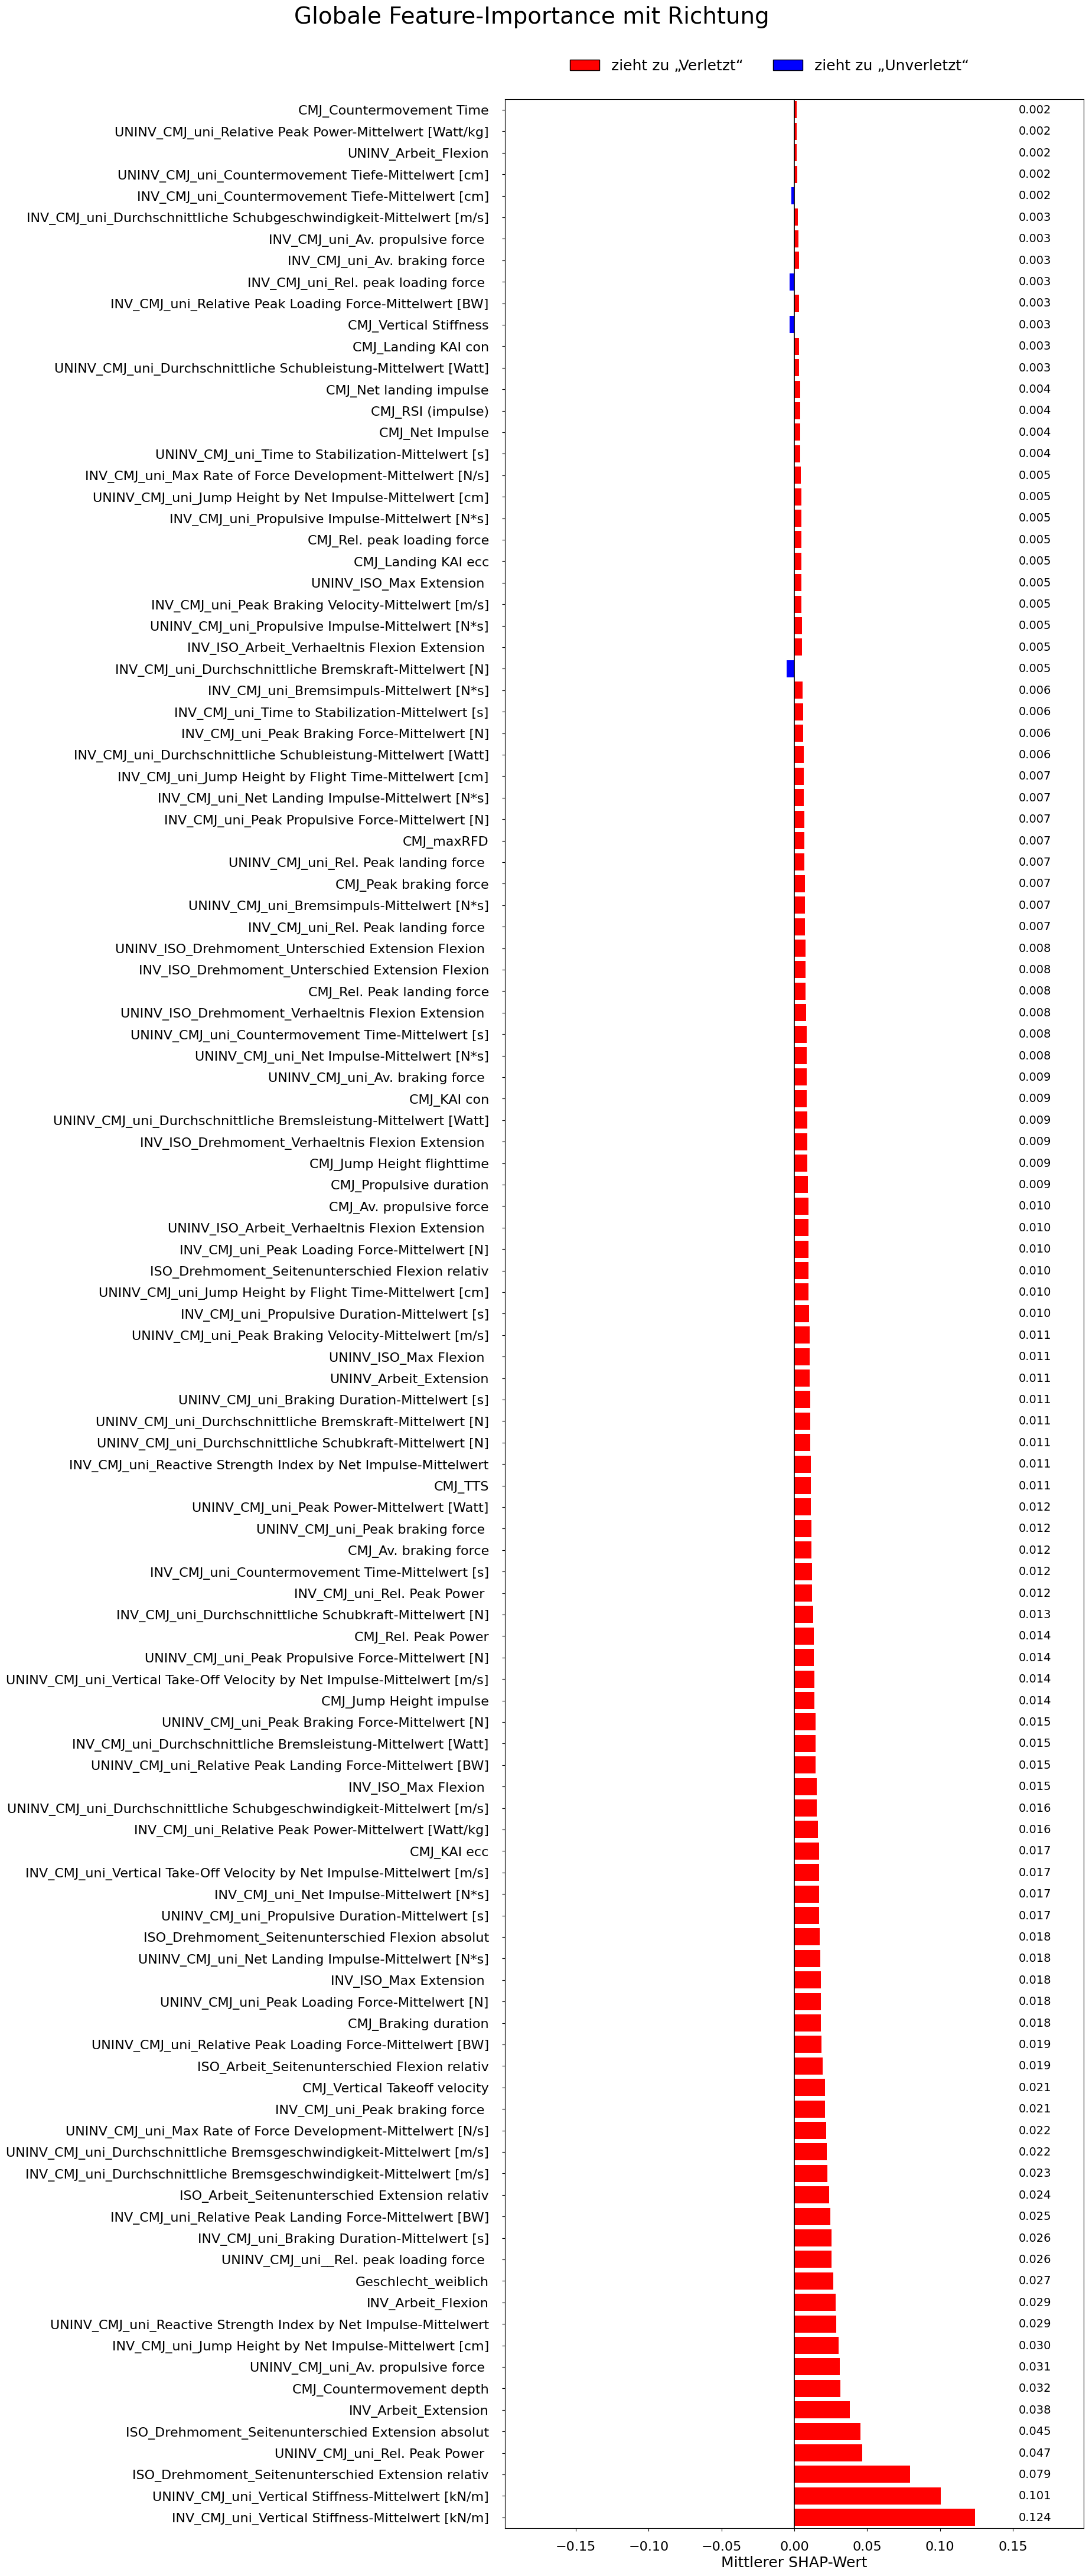

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

shap_output_dir = r"K:\Team\Böhmer_Michael\SHAP"

def plot_global_diverging_bar(
    features, 
    shap_stack, 
    output_dir, 
    title="Globale Feature-Importance mit Richtung",
    dpi=200
):
    """
    Zeichnet einen Diverging Bar-Plot:
      - rote Balken → höhere P(Verletzt),
      - blaue Balken → höhere P(Unverletzt).
    Ganz rechts außerhalb der Balken werden die absoluten mittleren SHAP-Werte
    angezeigt. Überschrift und Legende im Kopfbereich, Plot unten bündig.
    """
    # 1) Mittelwerte berechnen und sortieren
    mean_shap = np.mean(shap_stack, axis=0)
    idx_sort  = np.argsort(np.abs(mean_shap))[::-1]
    feat_sorted      = [features[i] for i in idx_sort]
    mean_shap_sorted = mean_shap[idx_sort]
    abs_sorted       = np.abs(mean_shap_sorted)
    colors           = ['red' if v>=0 else 'blue' for v in mean_shap_sorted]

    # 2) Puffer & Limits
    max_abs = abs_sorted.max()
    margin  = max_abs * 0.6

    # 3) Figur bauen
    fig_h = max(10, len(feat_sorted) * 0.4)
    fig_w = 14
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    # Überschrift im Kopfbereich, zentriert und größer
    fig.suptitle(title, fontsize=28, y=0.965, ha='right')

    # 4) Legende ebenfalls im Kopfbereich, zentriert unter dem Titel
    legend_elements = [
        Patch(facecolor='red',  edgecolor='k', label='zieht zu „Verletzt“'),
        Patch(facecolor='blue', edgecolor='k', label='zieht zu „Unverletzt“')
    ]
    fig.legend(
        handles=legend_elements,
        fontsize=18,
        loc='upper center',
        ncol=2,
        bbox_to_anchor=(0.5, 0.95),
        frameon=False
    )

    # 5) Balken zeichnen
    ax.barh(feat_sorted, mean_shap_sorted, color=colors, height=0.8)
    ax.axvline(0, color='black', linewidth=1.2)

    # 6) Achsen & Limits
    ax.set_xlabel("Mittlerer SHAP-Wert", fontsize=18)
    ax.tick_params(axis='y', labelsize=16, pad=16)
    ax.tick_params(axis='x', labelsize=16, pad=12)
    ax.set_xlim(-max_abs - margin, max_abs + margin)

    # 7) Zahlen ganz rechts
    x_text = max_abs + margin * 0.4
    for i, val in enumerate(abs_sorted):
        ax.text(
            x_text,
            i,
            f"{val:.3f}",
            va='center',
            ha='left',
            fontsize=14
        )

    # 8) Plot unten bündig anschließen
    ax.set_ylim(-0.5, len(feat_sorted)-0.5)
    ax.margins(y=0)

    # 9) Layout: Platz oben für Suptitle + Legend, bündig unten
    plt.subplots_adjust(top=0.93, bottom=0.02, left=0.18, right=0.88)

    # 10) Speichern & Anzeigen
    out = os.path.join(output_dir, "global_diverging_bar.png")
    fig.savefig(out, dpi=dpi, bbox_inches='tight')
    print(f"→ Globaler Diverging Bar-Plot: {out}")
    plt.show()

# Aufruf
plot_global_diverging_bar(
    features=features, 
    shap_stack=shap_stack, 
    output_dir=shap_output_dir
)


## Globaler Plot mit N wichtigtsen Features

→ Top-15-Plot gespeichert unter: K:\Team\Böhmer_Michael\SHAP\global_diverging_bar_top15_rest.png


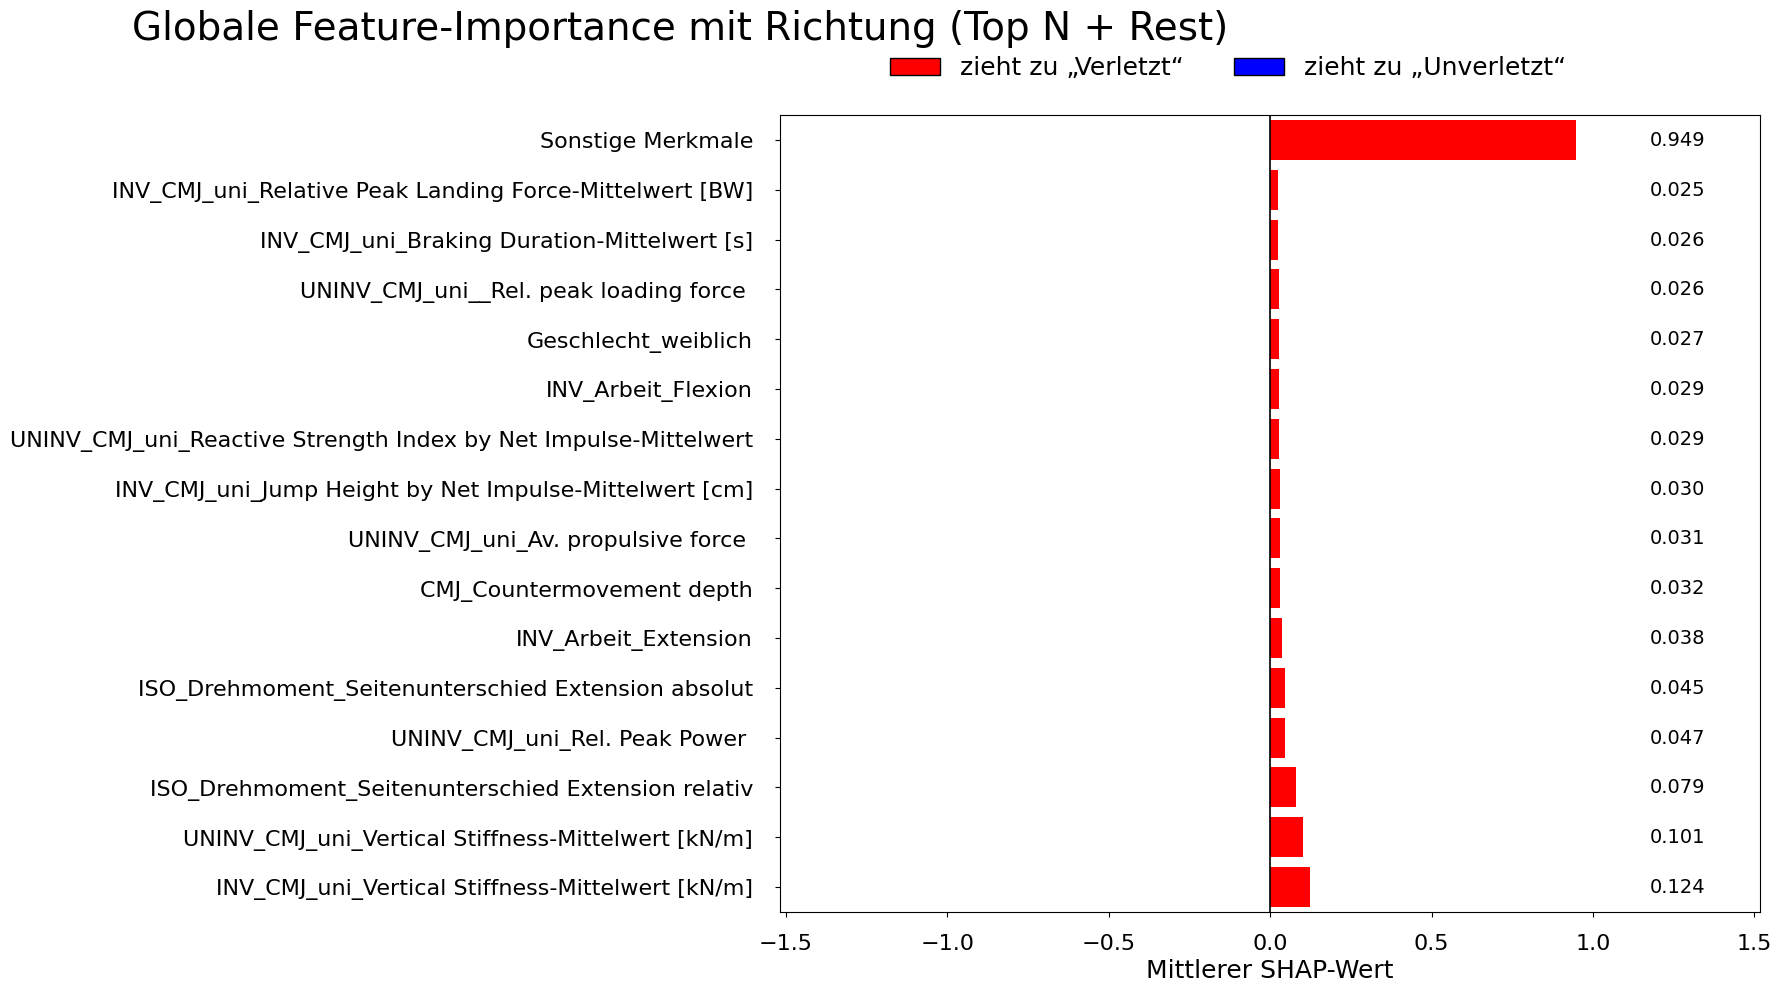

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_global_diverging_bar_topN_with_rest(
    features,
    shap_stack,
    output_dir,
    title="Globale Feature-Importance mit Richtung (Top N + Rest)",
    dpi=200,
    top_n=10  # NEU: Variable Anzahl an Top-Features
):
    mean_shap = np.mean(shap_stack, axis=0)
    abs_mean_shap = np.abs(mean_shap)
    idx_sort = np.argsort(abs_mean_shap)[::-1]

    # Top-N Features und Rest
    top_idxs = idx_sort[:top_n]
    rest_idxs = idx_sort[top_n:]

    top_features = [features[i] for i in top_idxs]
    top_values = mean_shap[top_idxs]
    top_colors = ['red' if val >= 0 else 'blue' for val in top_values]

    # "Rest" berechnen
    rest_value = np.sum(mean_shap[rest_idxs])
    rest_color = 'red' if rest_value >= 0 else 'blue'

    # Plot-Daten zusammenbauen
    bar_labels = top_features + ['Sonstige Merkmale']
    bar_values = np.append(top_values, rest_value)
    bar_colors = top_colors + [rest_color]
    abs_bar_values = np.abs(bar_values)

    # Plotgröße
    fig_h = max(6, len(bar_labels) * 0.6)
    fig_w = 14
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    
    # Legende im Kopfbereich
    legend_elements = [
        Patch(facecolor='red', edgecolor='k', label='zieht zu „Verletzt“'),
        Patch(facecolor='blue', edgecolor='k', label='zieht zu „Unverletzt“')
    ]
    # Titel und Legende im Kopfbereich kompakt zusammen
    fig.suptitle(title, fontsize=28, y=0.96, ha='right')

    fig.legend(
        handles=legend_elements,
        fontsize=18,
        loc='upper center',
        ncol=2,
        bbox_to_anchor=(0.5, 0.935),  # direkt unter dem Titel
        frameon=False
    )


    # Balken zeichnen
    ax.barh(bar_labels, bar_values, color=bar_colors, height=0.8)
    ax.axvline(0, color='black', linewidth=1.2)

    # Achsen & Beschriftung
    max_abs = abs_bar_values.max()
    margin = max_abs * 0.6
    ax.set_xlim(-max_abs - margin, max_abs + margin)
    ax.set_xlabel("Mittlerer SHAP-Wert", fontsize=18)
    ax.tick_params(axis='y', labelsize=16, pad=16)
    ax.tick_params(axis='x', labelsize=16, pad=12)

    # SHAP-Werte als Text rechts
    x_text = max_abs + margin * 0.4
    for i, val in enumerate(abs_bar_values):
        ax.text(
            x_text,
            i,
            f"{val:.3f}",
            va='center',
            ha='left',
            fontsize=14
        )

    # Layout optimieren
    ax.set_ylim(-0.5, len(bar_labels)-0.5)
    ax.margins(y=0)
    plt.subplots_adjust(top=0.85, bottom=0.02, left=0.18, right=0.88)

    # Speichern & Anzeigen
    out_path = os.path.join(output_dir, f"global_diverging_bar_top{top_n}_rest.png")
    fig.savefig(out_path, dpi=dpi, bbox_inches='tight')
    print(f"→ Top-{top_n}-Plot gespeichert unter: {out_path}")
    plt.show()

plot_global_diverging_bar_topN_with_rest(
    features=features,
    shap_stack=shap_stack,
    output_dir=shap_output_dir,
    top_n=15
)


## Lokaler Plot

→ Lokaler Waterfall-Plot mit Kopfzeile: K:\Team\Böhmer_Michael\SHAP\local_waterfall_85.png


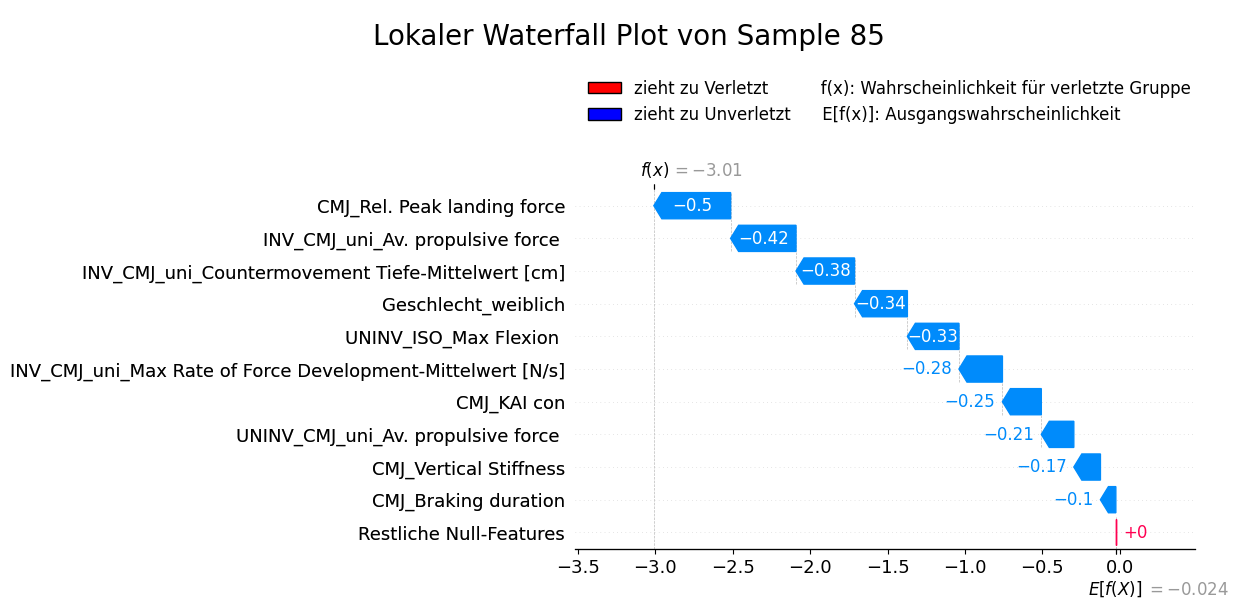

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shap
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch

shap_output_dir = r"K:\Team\Böhmer_Michael\SHAP"

def plot_local_waterfall(
    features,
    shap_stack,
    X_stack,
    exp_val,
    output_dir,
    sample_idx=None,
    dpi=200
):
    """
    Zeichnet einen lokalen SHAP-Waterfall-Plot mit:
      - Kopfzeile (Title + Legende) im oberen Bereich
      - Direkt darunter den Waterfall, tight am Rand
      - Zusammenfassung aller SHAP=0 Features
    """
    # 1) Sample wählen
    if sample_idx is None:
        np.random.seed(42)
        sample_idx = np.random.choice(shap_stack.shape[0], 1)[0]

    # 2) SHAP-Werte & -Namen
    orig_vals = shap_stack[sample_idx, :]
    orig_names = list(features)

    # 3) Null-Werte zusammenfassen
    zero_mask = orig_vals == 0
    vals_nz   = orig_vals[~zero_mask].tolist()
    names_nz  = [orig_names[i] for i in range(len(orig_names)) if not zero_mask[i]]
    if zero_mask.sum() > 0:
        names_nz.append("Restliche Null-Features")
        vals_nz.append(0.0)

    # 4) Explanation aufbauen
    exp = shap.Explanation(
        values        = np.array(vals_nz),
        base_values   = exp_val,
        feature_names = names_nz,
    )

    # 5) Figure + GridSpec: 20% Kopf, 80% Plot
    fig = plt.figure(figsize=(10, max(8, len(names_nz)*0.15) + 2))
    gs  = gridspec.GridSpec(
        nrows=2, ncols=1,
        height_ratios=[0.2, 0.8],
        hspace=0.4
    )

    # 6) Kopf-Bereich (unsichtbare Achse)
    ax_header = fig.add_subplot(gs[0])
    ax_header.axis("off")
    ax_header.text(
        0.5, 0.7,
        f"Lokaler Waterfall Plot von Sample {sample_idx}",
        ha="right", va="center",
        fontsize=20
    )

    # Patch-Legende in den Kopfbereich
    legend_elements = [
        Patch(facecolor='red',  edgecolor='k', label='zieht zu Verletzt          f(x): Wahrscheinlichkeit für verletzte Gruppe'),
        Patch(facecolor='blue', edgecolor='k', label='zieht zu Unverletzt      E[f(x)]: Ausgangswahrscheinlichkeit')
    ]
    ax_header.legend(
        handles=legend_elements,
        fontsize=12,
        loc='upper left',
        bbox_to_anchor=(0.01, 0.3),
        borderaxespad=0.,
        frameon=False
    )



    # 7) Plot-Bereich
    ax_plot = fig.add_subplot(gs[1])
    plt.sca(ax_plot)
    shap.plots.waterfall(
        exp,
        show=False,
        max_display=len(names_nz)
    )


    # 9) Tight am unteren Rand, Sortierung beibehalten
    ax_plot.set_ylim(-0.5, len(names_nz)-0.5)
    ax_plot.margins(y=0)
    plt.tight_layout(pad=0)

    # 9) Speichern und ausgeben
    out = os.path.join(output_dir, f"local_waterfall_{sample_idx}.png")
    fig.savefig(out, dpi=dpi, bbox_inches='tight')
    print(f"→ Lokaler Waterfall-Plot mit Kopfzeile: {out}")
    plt.show()


# Aufruf
plot_local_waterfall(
    features=features,
    shap_stack=shap_stack,
    X_stack=X_stack,
    exp_val=exp_val,
    output_dir=shap_output_dir,
    sample_idx=85   # None = zufälliges Sample
)

In [2]:
shap_output_dir = r"K:\Team\Böhmer_Michael\SHAP"

→ Lokaler Waterfall-Plot mit Kopfzeile: K:\Team\Böhmer_Michael\SHAP\local_waterfall_3.png


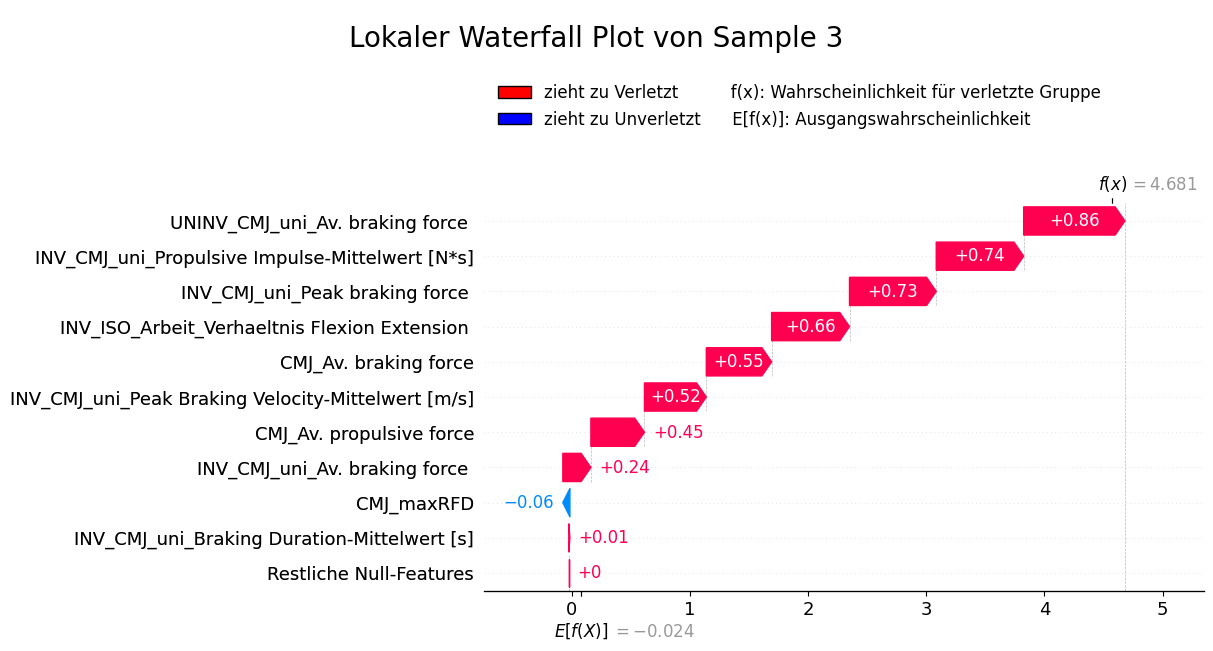

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shap
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch

shap_output_dir = r"K:\Team\Böhmer_Michael\SHAP"

def plot_local_waterfall(
    features,
    shap_stack,
    X_stack,
    exp_val,
    output_dir,
    sample_idx=None,
    dpi=200
):
    """
    Zeichnet einen lokalen SHAP-Waterfall-Plot mit:
      - Kopfzeile (Title + Legende) im oberen Bereich
      - Direkt darunter den Waterfall, tight am Rand
      - Zusammenfassung aller SHAP=0 Features
    """
    # 1) Sample wählen
    if sample_idx is None:
        np.random.seed(42)
        sample_idx = np.random.choice(shap_stack.shape[0], 1)[0]

    # 2) SHAP-Werte & -Namen
    orig_vals = shap_stack[sample_idx, :]
    orig_names = list(features)

    # 3) Null-Werte zusammenfassen
    zero_mask = orig_vals == 0
    vals_nz   = orig_vals[~zero_mask].tolist()
    names_nz  = [orig_names[i] for i in range(len(orig_names)) if not zero_mask[i]]
    if zero_mask.sum() > 0:
        names_nz.append("Restliche Null-Features")
        vals_nz.append(0.0)

    # 4) Explanation aufbauen
    exp = shap.Explanation(
        values        = np.array(vals_nz),
        base_values   = exp_val,
        feature_names = names_nz,
    )

    # 5) Figure + GridSpec: 20% Kopf, 80% Plot
    fig = plt.figure(figsize=(10, max(8, len(names_nz)*0.15) + 2))
    gs  = gridspec.GridSpec(
        nrows=2, ncols=1,
        height_ratios=[0.2, 0.8],
        hspace=0.4
    )

    # 6) Kopf-Bereich (unsichtbare Achse)
    ax_header = fig.add_subplot(gs[0])
    ax_header.axis("off")
    ax_header.text(
        0.5, 0.7,
        f"Lokaler Waterfall Plot von Sample {sample_idx}",
        ha="right", va="center",
        fontsize=20
    )

    # Patch-Legende in den Kopfbereich
    legend_elements = [
        Patch(facecolor='red',  edgecolor='k', label='zieht zu Verletzt          f(x): Wahrscheinlichkeit für verletzte Gruppe'),
        Patch(facecolor='blue', edgecolor='k', label='zieht zu Unverletzt      E[f(x)]: Ausgangswahrscheinlichkeit')
    ]
    ax_header.legend(
        handles=legend_elements,
        fontsize=12,
        loc='upper left',
        bbox_to_anchor=(0.01, 0.3),
        borderaxespad=0.,
        frameon=False
    )



    # 7) Plot-Bereich
    ax_plot = fig.add_subplot(gs[1])
    plt.sca(ax_plot)
    shap.plots.waterfall(
        exp,
        show=False,
        max_display=len(names_nz)
    )


    # 9) Tight am unteren Rand, Sortierung beibehalten
    # ax_plot.set_ylim(-0.5, len(names_nz)-0.5)
    # ax_plot.margins(y=0)
    # plt.tight_layout(pad=0)
    ax_plot.set_ylim(-0.5, len(names_nz)-0.5)
    ax_plot.margins(x=0.025, y=0.22)                          # 5% links/rechts, 2% oben/unten
    plt.tight_layout(pad=2)                                  # 2pt Abstand zu Figure-Rand
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05)  # 5% Abstand links/rechts/unten

    # 9) Speichern und ausgeben
    out = os.path.join(output_dir, f"local_waterfall_{sample_idx}.png")
    fig.savefig(out, dpi=dpi, bbox_inches='tight')
    print(f"→ Lokaler Waterfall-Plot mit Kopfzeile: {out}")
    plt.show()


# Aufruf
plot_local_waterfall(
    features=features,
    shap_stack=shap_stack,
    X_stack=X_stack,
    exp_val=exp_val,
    output_dir=shap_output_dir,
    sample_idx=3   # None = zufälliges Sample
)